# Detecting AI-Generated Images (CIFAKE)

In the past few years, researchers have developed machine learning techniques capable of generating media content (text, images, audio, etc.) that is increasingly difficult for humans to distinguish from similar "authentic" or non-AI-derived content. If employed by bad actors, such techniques may influence individuals and societies by causing people to believe in falsehoods. For this reason, it is critically important to develop methods of detecting AI-generated content.

The dataset of interest in this investigation is provided by Bird and Lofti at Nottingham Trent University. It consists of 60,000 images taken from CIFAR-10 along with the same number of images generated via a very popular latent diffusion model (https://huggingface.co/CompVis/stable-diffusion-v1-4). Of these, 50,000 images from each set are used for training and the remaining 10,000 for validation. Each image is a 32 x 32 RGB JPEG, and the entire dataset is referred to as CIFAKE. It is worth reading the original paper for further details, but in general, each image is either a real or a synthetic depiction of one of the following: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. Images are evenly distributed over these categories.

We are concerned not with categorizing the images according to their associated subject matter, but rather with determining whether a given image is authentic or originates from latent diffusion.

In [1]:
import os
import random
from matplotlib import pyplot as plt
import cv2

import numpy as np
import pandas as pd

from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.metrics import Precision, Recall

import keras_tuner as kt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [2]:
top_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images'
train_dir = top_dir + '/train'
test_dir = top_dir + '/test'

train_real = os.listdir(train_dir + '/REAL')
train_fake = os.listdir(train_dir + '/FAKE')

### Preliminary Analysis

In [3]:
# Plot k-number of images from the dataset

def plot_im(directory, k):

    files = os.listdir(directory)
    im = random.choices(files, k = k)

    fig = plt.figure()

    for i in range(k):
        im_i = cv2.imread(directory + im[i])
        fig.add_subplot(int(np.sqrt(k)), int(np.sqrt(k)), i + 1)
        plt.imshow(im_i)
        plt.axis('off')
    
    return plt

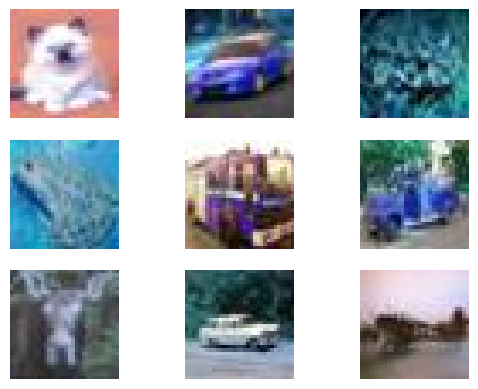

In [4]:
real_im = plot_im(directory = train_dir + '/REAL/', k = 9)

Above is a random selection of nine real images from CIFAKE. The images do not appear to be in any way correlated.

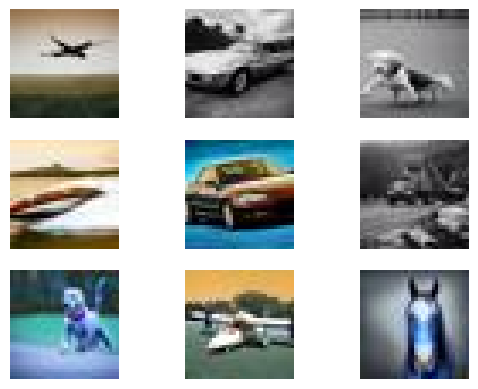

In [5]:
fake_im = plot_im(directory = train_dir + '/FAKE/', k = 9)

Here is a similar selection, this time of fake images. Notice that both sets are heavily compressed. With the possible exception of some unusual colorations, it is difficult to tell which images are real and which are fake.

### Analysis

In [6]:
# Generate tf datasets

train = image_dataset_from_directory(
    train_dir,
    label_mode = 'binary',
    image_size = (32, 32)
)

test = image_dataset_from_directory(
    test_dir,
    label_mode = 'binary',
    image_size = (32, 32)
)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [17]:
simple_model = Sequential([
    Rescaling(scale = 1./255),
    Conv2D(filters = 64, kernel_size = 3, activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = 3, activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units = 64),
    BatchNormalization(),
    Activation('relu'),
    Dense(units = 1, activation = 'sigmoid')
])

simple_model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', Precision(), Recall()]
)

simple_model.fit(train, validation_data = test, epochs = 5)

Epoch 1/5
3125/3125 [==============================] - 54s 17ms/step - loss: 0.2781 - accuracy: 0.8829 - precision_3: 0.8810 - recall_3: 0.8855 - val_loss: 0.7466 - val_accuracy: 0.7594 - val_precision_3: 0.6774 - val_recall_3: 0.9905
Epoch 2/5
3125/3125 [==============================] - 50s 16ms/step - loss: 0.2072 - accuracy: 0.9165 - precision_3: 0.9150 - recall_3: 0.9183 - val_loss: 0.1692 - val_accuracy: 0.9323 - val_precision_3: 0.9187 - val_recall_3: 0.9486
Epoch 3/5
3125/3125 [==============================] - 52s 17ms/step - loss: 0.1832 - accuracy: 0.9269 - precision_3: 0.9256 - recall_3: 0.9284 - val_loss: 0.2411 - val_accuracy: 0.8978 - val_precision_3: 0.8436 - val_recall_3: 0.9768
Epoch 4/5
3125/3125 [==============================] - 55s 18ms/step - loss: 0.1640 - accuracy: 0.9345 - precision_3: 0.9340 - recall_3: 0.9350 - val_loss: 0.2717 - val_accuracy: 0.8925 - val_precision_3: 0.8316 - val_recall_3: 0.9843
Epoch 5/5
3125/3125 [==============================] - 56s 1

An unoptimized convolutional neural network model is surprisingly capable of detecting fake images. This model is similar in architecture to the model proposed by the authors (Bird and Lofti) of the original paper.

In [8]:
# Hyperparameter tuning with keras_tuner

def model_builder(hp):
    
    # Hyperparameters
    dense_units = hp.Int('dense_units', min_value = 16, max_value = 128, step = 16)
    conv2d_filters_0 = hp.Int('conv_filters_0', min_value = 16, max_value = 128, step = 16)
    conv2d_filters_1 = hp.Int('conv_filters_1', min_value = 16, max_value = 128, step = 16)
    dropout_rate = hp.Int('dropout_rate', min_value = 0, max_value = 5, step = 1)
    learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    
    model = Sequential([
        Rescaling(scale = 1./255),
        Conv2D(filters = conv2d_filters_0, kernel_size = 3, activation = 'relu'),
        MaxPooling2D(),
        Conv2D(filters = conv2d_filters_1, kernel_size = 3, activation = 'relu'),
        MaxPooling2D(),
        Dropout(rate = dropout_rate/10),
        Flatten(),
        Dense(units = dense_units),
        BatchNormalization(),
        Activation('relu'),
        Dense(units = 1, activation = 'sigmoid')
    ])
    
    model.compile(
        optimizer = Adam(learning_rate = learning_rate),
        loss = 'binary_crossentropy',
        metrics = ['accuracy', Precision(), Recall()]
    )
    
    return model

In [9]:
# Optimize model for validation accuracy

stop_early = EarlyStopping(monitor = 'val_accuracy', patience = 3)

tuner = kt.Hyperband(
    hypermodel = model_builder,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor = 3,
    directory = 'tuning',
    overwrite = True
)

tuner.search(
    train,
    validation_data = test,
    callbacks = [stop_early]
)

Trial 30 Complete [00h 04m 09s]
val_accuracy: 0.8849999904632568

Best val_accuracy So Far: 0.935949981212616
Total elapsed time: 01h 45m 10s


It is interesting to explore how the model might perform with more carefully selected hyperparameters. The KerasTuner library allows for efficient hyperparameter tuning through the construction of a tuner object as above. The best validation accuracy achieved by the the tuner is 0.936, only slightly better than the best accuracy achieved by the simple model. This suggests that in this case, model performance is not a strong function of the precise values of most of the hyperparameters.

In [14]:
optimal_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(optimal_hps)

history = model.fit(
    train,
    validation_data = test,
    epochs = 20,
    callbacks = [stop_early]
)

Epoch 1/20


2023-05-01 22:55:56.831955: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3125/3125 [==============================] - 51s 16ms/step - loss: 0.3004 - accuracy: 0.8711 - precision_2: 0.8682 - recall_2: 0.8750 - val_loss: 0.2164 - val_accuracy: 0.9110 - val_precision_2: 0.9358 - val_recall_2: 0.8826
Epoch 2/20
3125/3125 [==============================] - 49s 16ms/step - loss: 0.2305 - accuracy: 0.9065 - precision_2: 0.9049 - recall_2: 0.9085 - val_loss: 0.1917 - val_accuracy: 0.9234 - val_precision_2: 0.9073 - val_recall_2: 0.9433
Epoch 3/20
3125/3125 [==============================] - 49s 16ms/step - loss: 0.2078 - accuracy: 0.9162 - precision_2: 0.9148 - recall_2: 0.9179 - val_loss: 0.2121 - val_accuracy: 0.9116 - val_precision_2: 0.8662 - val_recall_2: 0.9736
Epoch 4/20
3125/3125 [==============================] - 49s 16ms/step - loss: 0.1909 - accuracy: 0.9246 - precision_2: 0.9233 - recall_2: 0.9262 - val_loss: 0.1626 - val_accuracy: 0.9331 - val_precision_2: 0.9140 - val_recall_2: 0.9563
Epoch 5/20
3125/3125 [==============================] - 48s 15ms/st

It was not efficient to perform hyperparameter tuning with more than ten epochs. However, we can observe training of the best model topology out to more than that amount. The model with extended training achieves a validation accuracy of 0.951 and a reasonable balance of precision and recall.

### Results

In [15]:
model.summary()
model.save('/kaggle/working/')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 48)        1344      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 48)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 112)       48496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 112)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 112)        

The above model was found to be optimal within the selected toplogical constraints. With a validation accuracy of slightly greater than 0.95, this model can correctly identify a CIFAKE image as either real or fake in approximately 95% of cases. Whether this is sufficient for any specific operational requirements is beyond the scope of this project to assess. Regardless, this model provides at least a good starting point for further exploratory work.

### Discussion/Conclusion

This project served as an investigation into detection of AI-generated images and separately as an opportunity to learn how to use the KerasTuner library for optimizing neural network models. A convolutional neural network with approximately 440,000 parameters was able to distinguish between real and fake CIFAKE images with a validation accuracy of 0.95.

There are several limitations of this model, including those imposed by the selected topologies. A more complete treatment would consider more sophisticated toplogies, including attentional mechanisms (as noted by Bird and Lofti). Other limitations are inherent to the dataset -- the model accepts only images in the form of 32 x 32 RGB thumbnails. Many images can be processed into this form, but in many cases, significant information may be lost. If a latent diffusion model were to generate 512 x 512 images, it is possible that some of the features that uniquely identify the images as synthetic could be lost or significantly altered during downsampling. I suspect that a more operationalizable model would need to be trained on larger images. In this way, the model presented above serves more as a proof of concept than as a viable candidate for real-world use.

It is also worth reflecting on the required performance characteristics of the model. Which is more important -- precision or recall? If the purpose of the model is to provide human observers with information about the provenance of an image (or, in principle, any content), one might suggest that recall is the more important metric. That is, correctly labeling each synthetic image as such is the primary function of the model, regardless of whether some innocent images are falsely labeled. On the contrary, if the model incorrectly labels authentic images with a sufficiently high frequency, perhaps observers will learn to disregard or at least distrust the labels. For this reason, my perspective is that both precision and recall are important, although not necessarily in equal measure.

### Sources

* https://arxiv.org/abs/2303.14126
* https://www.tensorflow.org/tutorials/keras/keras_tuner
